In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia/'
# path = '/home/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

Using TensorFlow backend.


['woodOnRed', 'blackOnRed', 'redOnRed', 'redOnRed_white', 'navyOnWhite', 'blackOnBlack', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'stainOnWhite', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed', 'greenOnGreen']
100800


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [7]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [8]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

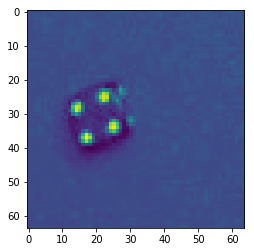

There are 4 dots, number is 9497


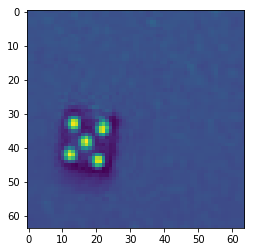

There are 5 dots, number is 10023


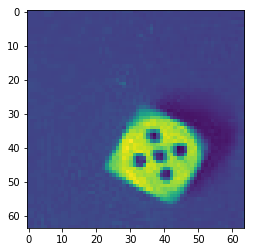

There are 5 dots, number is 2273


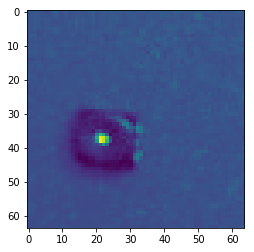

There are 1 dots, number is 3453


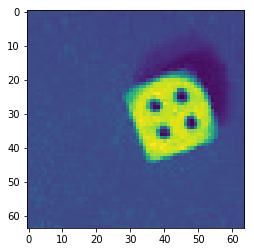

There are 4 dots, number is 1643


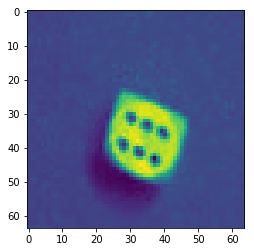

There are 6 dots, number is 2945


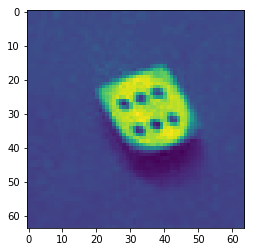

There are 6 dots, number is 2741


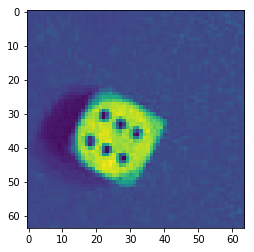

There are 6 dots, number is 2828


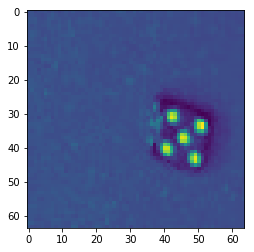

There are 5 dots, number is 9827


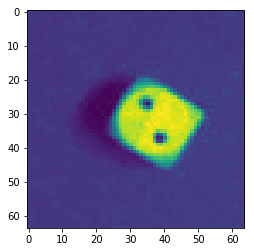

There are 2 dots, number is 759


In [9]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 10080)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [10]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [11]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(80640, 1, 64, 64) (20160, 1, 64, 64)


In [12]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(80640, 6) (20160, 6)


In [13]:
# create sequential model with 2NN layers
def base_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(1, 64, 64), data_format='channels_first', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(196, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels_values, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

In [14]:
# summarize model and apply checkpoints
model = base_model()
print(model.summary())
filepath = 'model2rms-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 60, 60)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 30, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 26, 32)        48032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               18264848  
_________________________________________________________________
dropout_2 (Dropout)          (None, 784)               0         
__________

In [11]:
# visualization of a model
plot_model(model, to_file='model2rms_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=2048, verbose=1, callbacks=callbacks_list)

Train on 80640 samples, validate on 20160 samples
Epoch 1/25
80640/80640 [==============================] - 36s 449us/step - loss: 1.9063 - acc: 0.1847 - val_loss: 1.7525 - val_acc: 0.2131
Epoch 2/25
80640/80640 [==============================] - 32s 394us/step - loss: 1.7682 - acc: 0.2158 - val_loss: 1.7563 - val_acc: 0.2194
Epoch 3/25
80640/80640 [==============================] - 32s 399us/step - loss: 1.7350 - acc: 0.2391 - val_loss: 1.6607 - val_acc: 0.2656
Epoch 4/25
80640/80640 [==============================] - 32s 397us/step - loss: 1.6782 - acc: 0.2592 - val_loss: 1.5946 - val_acc: 0.3074
Epoch 5/25
80640/80640 [==============================] - 32s 401us/step - loss: 1.6452 - acc: 0.2861 - val_loss: 1.6182 - val_acc: 0.2955
Epoch 6/25
80640/80640 [==============================] - 32s 397us/step - loss: 1.5808 - acc: 0.3113 - val_loss: 1.4283 - val_acc: 0.3610
Epoch 7/25
80640/80640 [==============================] - 32s 398us/step - loss: 1.5466 - acc: 0.3451 - val_loss: 1.

In [13]:
score = model.evaluate(X_test, y_test, verbose=1)

20160/20160 [==============================] - 4s 200us/step


In [14]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Accuracy: 84.35%
Test loss: 0.4163285477885178
Test accuracy 0.843452380952381


In [15]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 0.4163285477885178
acc: 0.843452380952381


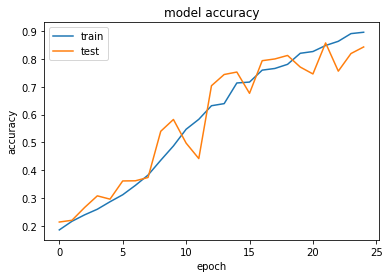

In [16]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

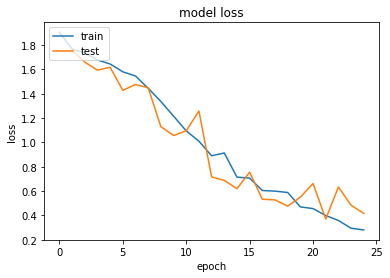

In [17]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model_json = model.to_json()
with open('model2rms_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2rms_weights.h5')
print('Saved model weights')

Saved model weights


In [15]:
new_model = load_model('model2rms-25-0.2806.h5')
filepath = 'model2rms_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [16]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

Epoch 1/10
80640/80640 [==============================] - 33s 413us/step - loss: 0.2417 - acc: 0.9109
Epoch 2/10
80640/80640 [==============================] - 30s 367us/step - loss: 0.2470 - acc: 0.9104
Epoch 3/10
80640/80640 [==============================] - 30s 374us/step - loss: 0.2325 - acc: 0.9207
Epoch 4/10
80640/80640 [==============================] - 30s 372us/step - loss: 0.3246 - acc: 0.9043
Epoch 5/10
80640/80640 [==============================] - 30s 374us/step - loss: 0.2064 - acc: 0.9292
Epoch 6/10
80640/80640 [==============================] - 30s 372us/step - loss: 0.1301 - acc: 0.9542
Epoch 7/10
80640/80640 [==============================] - 30s 374us/step - loss: 0.2170 - acc: 0.9274
Epoch 8/10
80640/80640 [==============================] - 30s 372us/step - loss: 0.1021 - acc: 0.9646
Epoch 9/10
80640/80640 [==============================] - 30s 369us/step - loss: 0.1479 - acc: 0.9507
Epoch 10/10
80640/80640 [==============================] - 30s 371us/step - loss: 

In [17]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))

20160/20160 [==============================] - 4s 203us/step
training results:
loss: 0.3136579115357664
acc: 0.9078373015873016


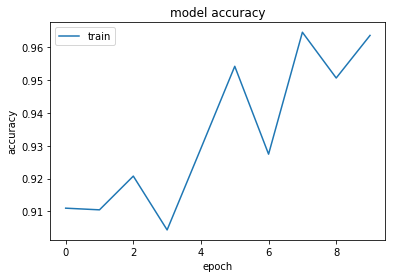

In [18]:
plt.plot(new_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

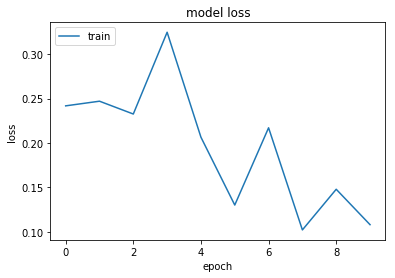

In [19]:
plt.plot(new_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model_json = model.to_json()
with open('model2adam_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2adam_weights_continue.h5')
print('Saved model weights')

Saved model weights
